In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,valid_data,valid_label = pickle.load(f)
    return train_data,train_label,valid_data,valid_label

# data_path = 'adress_512.pkl'
data_path = 'adress_pssat.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,valid_data,valid_label = load_data(data_path)

# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(train_y.shape[0]).astype(float);
train_y = torch.from_numpy(train_y)


# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(CTX),train_y.to(CTX)) # create your datset

 # create your dataloader


In [2]:
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(val_y.shape[0]).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data

val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
# val_size = 297
# train_size = train_x.size(0) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 2379
#Length of Validation Data : 297

#load the train and validation into batches.
train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import recall_score as recall
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out, _softmax= self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out, _softmax = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(_softmax, labels.to(torch.int64).cuda())           # Calculate accuracy
        
        valid_conf = confusion(np.argmax(_softmax.cpu(),1),labels.cpu())
#         valid_conf = 8008
#         print(np.argmax(out.cpu(),1))
#         print(labels.cpu())
        print ('Valid Confusion Matrix:["cc","cd"]')
        print(valid_conf)
        print ('Recall')
        print(recall(np.argmax(_softmax.cpu(),1),labels.cpu(),average='macro'))
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.8f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
#         print (result['valid_conf'])

In [5]:
import numpy as np
import torch
from torch import nn
from torch.nn import init

class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.shape[0],-1)

class ChannelAttention(nn.Module):
    def __init__(self,channel,reduction=16,num_layers=3):
        super().__init__()
        self.avgpool=nn.AdaptiveAvgPool2d(1)
        gate_channels=[channel]
        gate_channels+=[channel//reduction]*num_layers
        gate_channels+=[channel]


        self.ca=nn.Sequential()
        self.ca.add_module('flatten',Flatten())
        for i in range(len(gate_channels)-2):
            self.ca.add_module('fc%d'%i,nn.Linear(gate_channels[i],gate_channels[i+1]))
            self.ca.add_module('bn%d'%i,nn.BatchNorm1d(gate_channels[i+1]))
            self.ca.add_module('relu%d'%i,nn.ReLU())
        self.ca.add_module('last_fc',nn.Linear(gate_channels[-2],gate_channels[-1]))
        

    def forward(self, x) :
        res=self.avgpool(x)
        res=self.ca(res)
        res=res.unsqueeze(-1).unsqueeze(-1).expand_as(x)
        return res

class SpatialAttention(nn.Module):
    def __init__(self,channel,reduction=16,num_layers=3,dia_val=2):
        super().__init__()
        self.sa=nn.Sequential()
        self.sa.add_module('conv_reduce1',nn.Conv2d(kernel_size=1,in_channels=channel,out_channels=channel//reduction))
        self.sa.add_module('bn_reduce1',nn.BatchNorm2d(channel//reduction))
        self.sa.add_module('relu_reduce1',nn.ReLU())
        for i in range(num_layers):
            self.sa.add_module('conv_%d'%i,nn.Conv2d(kernel_size=3,in_channels=channel//reduction,out_channels=channel//reduction,padding=1,dilation=dia_val))
            self.sa.add_module('bn_%d'%i,nn.BatchNorm2d(channel//reduction))
            self.sa.add_module('relu_%d'%i,nn.ReLU())
        self.sa.add_module('last_conv',nn.Conv2d(channel//reduction,1,kernel_size=1))

    def forward(self, x) :
        res=self.sa(x)
        res=res.expand_as(x)
        return res




class BAMBlock(nn.Module):

    def __init__(self, channel=512,reduction=16,dia_val=2):
        super().__init__()
        self.ca=ChannelAttention(channel=channel,reduction=reduction)
        self.sa=SpatialAttention(channel=channel,reduction=reduction,dia_val=dia_val)
        self.sigmoid=nn.Sigmoid()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        sa_out=self.sa(x)
        ca_out=self.ca(x)
        weight=self.sigmoid(sa_out+ca_out)
        out=(1+weight)*x
        return out


# if __name__ == '__main__':
#     input=torch.randn(50,512,7,7)
#     bam = BAMBlock(channel=512,reduction=16,dia_val=2)
#     output=bam(input)
#     print(output.shape)
    

#                   Conv2d(120, 256, kernel_size=(3,3), stride=(1,1), padding='same'),
# #               MaxPool2d(kernel_size=(2,2)),
# #               Conv2d(256, 384, kernel_size=(2,2), padding='same'),
# #               MaxPool2d(kernel_size=1, stride=0),
# #               Conv2d(128, 1, kernel_size=(3,3), stride=(1,1), padding='same'),
#               torch.nn.AvgPool2d(kernel_size=(2,2), stride=1),
#               BatchNorm2d(256),
#               ReLU(inplace=True),
class BAM(ImageClassificationBase):   
    def __init__(self):
        super(BAM, self).__init__()
        #The LW_CNN module utilizes three convolutions (C), two max-pooling
        # (MP), one average-pooling (AP), and one batch normalization
        # (BN) layer.
        self.LW_CNN1 = Sequential(
              Conv2d(3, 256, kernel_size=(2,2), stride=(2,2), padding=0),
              MaxPool2d(kernel_size=(2,2), stride=None),
        )
        self.attention1 = BAMBlock(channel=256,reduction=4,dia_val=1)
        self.LW_CNN2 = Sequential(
              Conv2d(256, 128, kernel_size=(2,2), stride=(2,2), padding=0),
              MaxPool2d(kernel_size=(2,2), stride=None),
        )

        self.linear_layers = Sequential(
            Linear(136 , 4),
#             Linear(256, 64),
            Linear(4, 2)
#             Linear(16, 2)
        )
        self.attention2 = BAMBlock(channel=128,reduction=4,dia_val=1)
        self.LW_CNN3 = Sequential(
              Conv2d(128, 64, kernel_size=(1,1), stride=(1,1), padding=0),
              torch.nn.AvgPool2d(kernel_size=(2,2), stride=1),
              BatchNorm2d(64)
        )
        self.attention3 = BAMBlock(channel=64,reduction=8,dia_val=1)
        self.LW_CNN4 = Sequential(
              Conv2d(64, 32, kernel_size=(1,1), stride=(1,1), padding=0),
              Conv2d(32, 16, kernel_size=(1,1), stride=(1,1), padding=0),
              Conv2d(16, 8, kernel_size=(1,1), stride=(1,1), padding=0),
        )
        self.softmax_out = nn.Softmax(dim=1)

    # Defining the forward pass    
    def forward(self, x):
#         x = x.view(-1, x.size(3),x.size(2),x.size(1))
#         print(x.size)
        x = self.LW_CNN1(x)
        x = self.attention1(x)
        x = self.LW_CNN2(x)
        x = self.attention2(x)
        x = self.LW_CNN3(x)
        x = self.attention3(x)
        x = self.LW_CNN4(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        output_softmax = self.softmax_out(x)
        return x,output_softmax

In [6]:
# defining the model
model = BAM()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function

criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

BAM(
  (LW_CNN1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(2, 2), stride=(2, 2))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (attention1): BAMBlock(
    (ca): ChannelAttention(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (ca): Sequential(
        (flatten): Flatten()
        (fc0): Linear(in_features=256, out_features=64, bias=True)
        (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU()
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (fc2): Linear(in_features=64, out_features=64, bias=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (last_fc): Linear(in_features=64, out_features=256, bias=True)
      )
    )
    (sa): Spati

In [7]:
# !pip install torch-summary
from torchsummary import summary
summary(model, (3, 300, 40))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 75, 10]         --
|    └─Conv2d: 2-1                       [-1, 256, 150, 20]        3,328
|    └─MaxPool2d: 2-2                    [-1, 256, 75, 10]         --
├─BAMBlock: 1-2                          [-1, 256, 75, 10]         --
|    └─SpatialAttention: 2-3             [-1, 256, 75, 10]         --
|    |    └─Sequential: 3-1              [-1, 1, 75, 10]           127,809
|    └─ChannelAttention: 2-4             [-1, 256, 75, 10]         --
|    |    └─AdaptiveAvgPool2d: 3-2       [-1, 256, 1, 1]           --
|    |    └─Sequential: 3-3              [-1, 256]                 41,792
|    └─Sigmoid: 2-5                      [-1, 256, 75, 10]         --
├─Sequential: 1-3                        [-1, 128, 18, 2]          --
|    └─Conv2d: 2-6                       [-1, 128, 37, 5]          131,200
|    └─MaxPool2d: 2-7                    [-1, 128, 18, 2]          -

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 75, 10]         --
|    └─Conv2d: 2-1                       [-1, 256, 150, 20]        3,328
|    └─MaxPool2d: 2-2                    [-1, 256, 75, 10]         --
├─BAMBlock: 1-2                          [-1, 256, 75, 10]         --
|    └─SpatialAttention: 2-3             [-1, 256, 75, 10]         --
|    |    └─Sequential: 3-1              [-1, 1, 75, 10]           127,809
|    └─ChannelAttention: 2-4             [-1, 256, 75, 10]         --
|    |    └─AdaptiveAvgPool2d: 3-2       [-1, 256, 1, 1]           --
|    |    └─Sequential: 3-3              [-1, 256]                 41,792
|    └─Sigmoid: 2-5                      [-1, 256, 75, 10]         --
├─Sequential: 1-3                        [-1, 128, 18, 2]          --
|    └─Conv2d: 2-6                       [-1, 128, 37, 5]          131,200
|    └─MaxPool2d: 2-7                    [-1, 128, 18, 2]          -

In [8]:
# input=torch.randn(50,256,7,7)
# bam = BAMBlock(channel=256,reduction=16,dia_val=2)
# output=bam(input)
# print(output.shape)

In [9]:
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

  
# def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
#     history = []
#     optimizer = opt_func(model.parameters(),lr)
#     for epoch in range(epochs):
        
#         model.train()
#         train_losses = []
#         for batch in train_loader:
#             loss = model.training_step(batch)
#             train_losses.append(loss)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
            
#         result = evaluate(model, val_loader)
#         result['train_loss'] = torch.stack(train_losses).mean().item()
#         model.epoch_end(epoch, result)
#         history.append(result)
    
#     return history 

In [10]:
# # CTX = torch.device('cuda')
# # train_dl.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # # train_dl.train_labels.to(CTX)
# # # val_dl.train_data.to(CTX)  #train_dataset.train_data is a Tensor(input data)
# # # val_dl.train_labels.to(CTX)
# num_epochs = 24
# opt_func = torch.optim.Adam
# lr = 0.007
# #fitting the model on training data and record the result after each epoch
# history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


In [11]:
# import matplotlib.pyplot as plt

# def plot_accuracies(history):
#     """ Plot the history of accuracies"""
#     accuracies = [x['val_acc'] for x in history]
#     plt.plot(accuracies, '-x')
#     plt.xlabel('epoch')
#     plt.ylabel('accuracy')
#     plt.title('Accuracy vs. No. of epochs');
    

# plot_accuracies(history)

# def plot_losses(history):
#     """ Plot the losses in each epoch"""
#     train_losses = [x.get('train_loss') for x in history]
#     val_losses = [x['val_loss'] for x in history]
#     plt.plot(train_losses, '-bx')
#     plt.plot(val_losses, '-rx')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.legend(['Training', 'Validation'])
#     plt.title('Loss vs. No. of epochs');

# plot_losses(history)

In [12]:
# max([x['val_acc'] for x in history])

In [13]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [14]:
# get training set size to calculate # iterations and minibatch indices
train_size = train_x.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = BAM().to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []
best_val_acc = 0
best_epoch = 0
valid_acc = 0
# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):
    
    best_val_acc = 0
    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
           
        if valid_acc > best_val_acc:
            best_epoch = epoch
            best_val_acc = valid_acc
            print("Best one is",epoch,best_val_acc)
             # Save checkpoint of the model
            checkpoint_filename = 'checkpoint/BAM-{:03d}.pkl'.format(epoch)
            save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

cuda selected
Number of trainable params:  362265


In [15]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 100

# train it!
train(optimizer, model, num_epochs, train_x, train_y, val_x, val_y)

C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/776434586.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, device=device).float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/776434586.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)


Epoch 0: iteration 74/75Best one is 0 tensor(60.1562, device='cuda:0')

Epoch 0 --- loss:0.678, Epoch accuracy:56.69%, Validation loss:0.669, Validation accuracy:60.16%


C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/776434586.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid_tensor = torch.tensor(X_valid,device=device).float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/776434586.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)


Epoch 1: iteration 74/75
Epoch 1 --- loss:0.668, Epoch accuracy:58.68%, Validation loss:0.668, Validation accuracy:58.59%
Epoch 2: iteration 74/75
Epoch 2 --- loss:0.667, Epoch accuracy:59.43%, Validation loss:0.658, Validation accuracy:59.38%
Epoch 3: iteration 74/75
Epoch 3 --- loss:0.661, Epoch accuracy:60.67%, Validation loss:0.659, Validation accuracy:58.59%
Epoch 4: iteration 74/75Best one is 4 tensor(67.1875, device='cuda:0')

Epoch 4 --- loss:0.652, Epoch accuracy:61.87%, Validation loss:0.646, Validation accuracy:67.19%
Epoch 5: iteration 74/75
Epoch 5 --- loss:0.631, Epoch accuracy:64.65%, Validation loss:0.657, Validation accuracy:60.94%
Epoch 6: iteration 74/75
Epoch 6 --- loss:0.626, Epoch accuracy:65.06%, Validation loss:0.637, Validation accuracy:65.62%
Epoch 7: iteration 74/75Best one is 7 tensor(68.7500, device='cuda:0')

Epoch 7 --- loss:0.622, Epoch accuracy:64.90%, Validation loss:0.605, Validation accuracy:68.75%
Epoch 8: iteration 74/75
Epoch 8 --- loss:0.610, Epo

Epoch 64: iteration 74/75
Epoch 64 --- loss:0.144, Epoch accuracy:94.16%, Validation loss:0.770, Validation accuracy:69.53%
Epoch 65: iteration 74/75
Epoch 65 --- loss:0.150, Epoch accuracy:93.24%, Validation loss:1.501, Validation accuracy:72.66%
Epoch 66: iteration 74/75
Epoch 66 --- loss:0.130, Epoch accuracy:94.36%, Validation loss:0.857, Validation accuracy:74.22%
Epoch 67: iteration 74/75
Epoch 67 --- loss:0.153, Epoch accuracy:93.04%, Validation loss:0.701, Validation accuracy:75.00%
Epoch 68: iteration 74/75
Epoch 68 --- loss:0.129, Epoch accuracy:94.03%, Validation loss:1.209, Validation accuracy:70.31%
Epoch 69: iteration 74/75
Epoch 69 --- loss:0.122, Epoch accuracy:94.36%, Validation loss:1.627, Validation accuracy:71.88%
Epoch 70: iteration 74/75
Epoch 70 --- loss:0.108, Epoch accuracy:95.40%, Validation loss:1.223, Validation accuracy:66.41%
Epoch 71: iteration 74/75
Epoch 71 --- loss:0.119, Epoch accuracy:95.28%, Validation loss:1.775, Validation accuracy:64.06%
Epoch 72

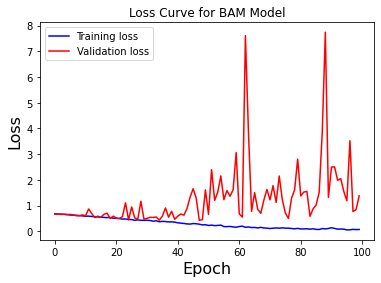

In [16]:
import matplotlib.pyplot as plt

plt.title('Loss Curve for BAM Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [18]:
import os
# pick load folder  
load_folder = 'checkpoint'  

# pick the epoch to load
epoch = '076'
model_name = f'BAM-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary 
model = BAM()
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoint\BAM-076.pkl


In [19]:
validate = make_validate_fnc(model,criterion)

X_val = val_x
y_val = val_y
# Convert 4D test feature set array to tensor and move to GPU
X_val_tensor = torch.tensor(X_val,device='cpu').float()
# Convert 4D test label set array to tensor and move to GPU
y_val_tensor = torch.tensor(y_val,dtype=torch.long,device='cpu')

# Get the model's performance metrics using the validation function we defined
_loss, _acc, predicted_emotions = validate(X_val_tensor,y_val_tensor)

print(f'Validation accuracy is {_acc:.2f}%')

C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/2725604674.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val,device='cpu').float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/2725604674.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val,dtype=torch.long,device='cpu')


Validation accuracy is 81.25%


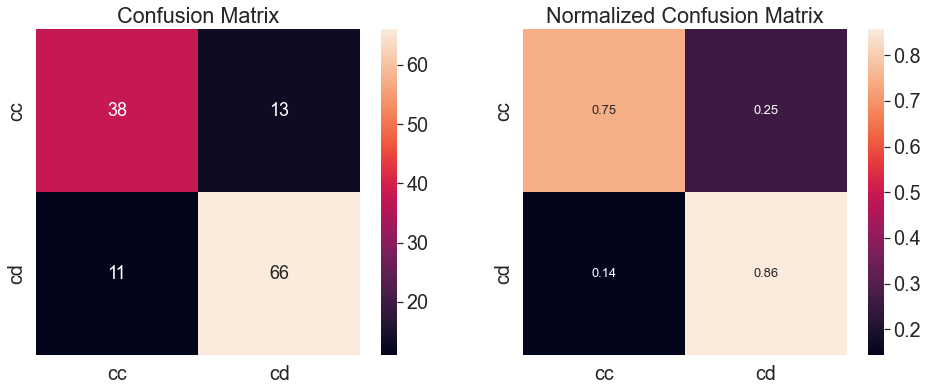

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions
# use labels from test set
emotions_groundtruth = y_val

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = ['cc', 'cd']

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

ToDo: Make X_Test and Y_Test, Confusion Matrix, 

In [21]:
data_path = 'adress_test_3_channles.pkl'

X_test,Y_test,speaker,segment = load_data(data_path)
# converting training images into torch format
X_test  = torch.from_numpy(X_test)

# converting the target into torch format

Y_test = Y_test.reshape(Y_test.shape[0]).astype(float);
y_test = torch.from_numpy(Y_test)

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test,device='cpu').float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device='cpu')

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/738736624.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test,device='cpu').float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_16776/738736624.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test,dtype=torch.long,device='cpu')


Test accuracy is 63.37%


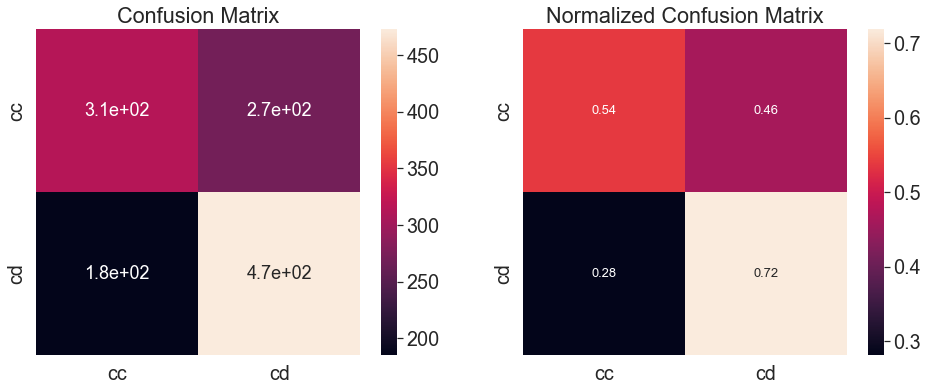

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = ['cc', 'cd']

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [23]:
speaker_dict = {}
for spk,seg,emo, y in zip(speaker,segment,predicted_emotions,y_test):
    print(spk,seg,emo.cpu(), y.cpu())
    speaker_dict[spk] = y.item()

S160.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 6 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 10 tensor(0) tensor(0., dtype=torch.f

S184.wav 14 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 15 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 16 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 17 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 18 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 19 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 20 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 21 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 22 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 23 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 24 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 25 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 26 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 27 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 28 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 29 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 30 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 31 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 32 tensor(1) tensor

S167.wav 77 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 78 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 79 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 80 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 81 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 82 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 83 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 84 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 85 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 86 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 87 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 88 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 0 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 1 tensor(0) tensor(1., dtype=torch.float64)
S168.wav 2 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 3 tensor(0) tensor(1., dtype=torch.float64)
S168.wav 4 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 5 tensor(0) tensor(1., dtype=torch.float64)
S168.wav 6 tensor(1) tensor(1., dt

S190.wav 6 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 7 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 8 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 9 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 10 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 11 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 12 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 13 tensor(0) tensor(1., dtype=torch.float64)
S190.wav 14 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 15 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 16 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 17 tensor(0) tensor(1., dtype=torch.float64)
S190.wav 18 tensor(0) tensor(1., dtype=torch.float64)
S190.wav 19 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 20 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 21 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 22 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 23 tensor(1) tensor(1., dtype=torch.float64)
S190.wav 24 tensor(0) tensor(1.,

In [24]:
speaker_dict

{'S160.wav': 0.0,
 'S161.wav': 0.0,
 'S163.wav': 0.0,
 'S166.wav': 0.0,
 'S170.wav': 0.0,
 'S172.wav': 0.0,
 'S174.wav': 0.0,
 'S175.wav': 0.0,
 'S177.wav': 0.0,
 'S178.wav': 0.0,
 'S180.wav': 0.0,
 'S183.wav': 0.0,
 'S184.wav': 0.0,
 'S186.wav': 0.0,
 'S193.wav': 0.0,
 'S195.wav': 0.0,
 'S196.wav': 0.0,
 'S197.wav': 0.0,
 'S199.wav': 0.0,
 'S201.wav': 0.0,
 'S202.wav': 0.0,
 'S204.wav': 0.0,
 'S206.wav': 0.0,
 'S207.wav': 0.0,
 'S162.wav': 1.0,
 'S164.wav': 1.0,
 'S165.wav': 1.0,
 'S167.wav': 1.0,
 'S168.wav': 1.0,
 'S169.wav': 1.0,
 'S171.wav': 1.0,
 'S173.wav': 1.0,
 'S176.wav': 1.0,
 'S179.wav': 1.0,
 'S181.wav': 1.0,
 'S182.wav': 1.0,
 'S185.wav': 1.0,
 'S188.wav': 1.0,
 'S189.wav': 1.0,
 'S190.wav': 1.0,
 'S191.wav': 1.0,
 'S192.wav': 1.0,
 'S194.wav': 1.0,
 'S198.wav': 1.0,
 'S200.wav': 1.0,
 'S203.wav': 1.0,
 'S205.wav': 1.0}

In [25]:
output_dict = {}

for spk,seg,emo, y in zip(speaker,segment,predicted_emotions,y_test):
    print(spk,seg,emo.cpu(), y.cpu())
    output_dict[spk] = []

S160.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 6 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 10 tensor(0) tensor(0., dtype=torch.f

S193.wav 10 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 11 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 12 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 13 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 14 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 15 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 16 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 17 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 18 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 19 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 20 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 21 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 22 tensor(0) tensor(0., dtype=torch.float64)
S195.wav 0 tensor(1) tensor(0., dtype=torch.float64)
S195.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S195.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S195.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S195.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S195.wav 5 tensor(0) tensor(0., d

S169.wav 15 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 16 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 17 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 18 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 19 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 20 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 0 tensor(1) tensor(1., dtype=torch.float64)
S171.wav 1 tensor(1) tensor(1., dtype=torch.float64)
S171.wav 2 tensor(1) tensor(1., dtype=torch.float64)
S171.wav 3 tensor(1) tensor(1., dtype=torch.float64)
S171.wav 4 tensor(1) tensor(1., dtype=torch.float64)
S171.wav 5 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 6 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 7 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 8 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 9 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 10 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 11 tensor(0) tensor(1., dtype=torch.float64)
S171.wav 12 tensor(0) tensor(1., dtype

S191.wav 12 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 13 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 14 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 15 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 16 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 17 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 18 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 19 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 20 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 21 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 22 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 23 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 24 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 25 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 26 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 27 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 28 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 29 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 30 tensor(0) tensor

In [26]:
output_dict

{'S160.wav': [],
 'S161.wav': [],
 'S163.wav': [],
 'S166.wav': [],
 'S170.wav': [],
 'S172.wav': [],
 'S174.wav': [],
 'S175.wav': [],
 'S177.wav': [],
 'S178.wav': [],
 'S180.wav': [],
 'S183.wav': [],
 'S184.wav': [],
 'S186.wav': [],
 'S193.wav': [],
 'S195.wav': [],
 'S196.wav': [],
 'S197.wav': [],
 'S199.wav': [],
 'S201.wav': [],
 'S202.wav': [],
 'S204.wav': [],
 'S206.wav': [],
 'S207.wav': [],
 'S162.wav': [],
 'S164.wav': [],
 'S165.wav': [],
 'S167.wav': [],
 'S168.wav': [],
 'S169.wav': [],
 'S171.wav': [],
 'S173.wav': [],
 'S176.wav': [],
 'S179.wav': [],
 'S181.wav': [],
 'S182.wav': [],
 'S185.wav': [],
 'S188.wav': [],
 'S189.wav': [],
 'S190.wav': [],
 'S191.wav': [],
 'S192.wav': [],
 'S194.wav': [],
 'S198.wav': [],
 'S200.wav': [],
 'S203.wav': [],
 'S205.wav': []}

In [27]:
for spk,seg,emo, y in zip(speaker,segment,predicted_emotions,y_test):
    print(spk,seg,emo.cpu(), y.cpu())
    output_dict[spk].append(emo.item())

S160.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 6 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 10 tensor(0) tensor(0., dtype=torch.f

S183.wav 14 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 15 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 16 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 17 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 18 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 19 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 20 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 21 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 22 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 23 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 24 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 25 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 26 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 27 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 28 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 29 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 30 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 31 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 32 tensor(0) tensor

S201.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 8 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 9 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 10 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 11 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 12 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 13 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 14 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 15 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 16 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 17 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 18 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 2 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 3 tensor(1) tensor(0., dtype

S167.wav 47 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 48 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 49 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 50 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 51 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 52 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 53 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 54 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 55 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 56 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 57 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 58 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 59 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 60 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 61 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 62 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 63 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 64 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 65 tensor(1) tensor

S189.wav 0 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 1 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 2 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 3 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 4 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 5 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 6 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 7 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 8 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 9 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 10 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 11 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 12 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 13 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 14 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 15 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 16 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 17 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 18 tensor(1) tensor(1., dtype

In [28]:
output_dict

{'S160.wav': [0, 0, 0, 1, 0, 0, 1, 1],
 'S161.wav': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'S163.wav': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0],
 'S166.wav': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 'S170.wav': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'S172.wav': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0],
 'S174.wav': [0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1],
 'S175.

In [29]:
sum([1,0,4])

5

In [30]:
results_dict = {}
for spk in output_dict:
    summition = sum(output_dict[spk])
    length = len(output_dict[spk])
    ad = 0
    if(summition/length<0.3):
        ad = 0.0
    else:
        ad = 1.0
    results_dict[spk] = ad
#     print(summition/length)

In [31]:
tp = 0
fp = 0
tn = 0
fn = 0
wrong_prediction = 0
for spk in output_dict:
   
    res = results_dict[spk]
    test = speaker_dict[spk]
    print(spk,res,test)
    if(res != test):
        wrong_prediction += 1
wrong_prediction

S160.wav 1.0 0.0
S161.wav 0.0 0.0
S163.wav 0.0 0.0
S166.wav 0.0 0.0
S170.wav 0.0 0.0
S172.wav 0.0 0.0
S174.wav 1.0 0.0
S175.wav 1.0 0.0
S177.wav 1.0 0.0
S178.wav 1.0 0.0
S180.wav 1.0 0.0
S183.wav 0.0 0.0
S184.wav 0.0 0.0
S186.wav 1.0 0.0
S193.wav 1.0 0.0
S195.wav 0.0 0.0
S196.wav 0.0 0.0
S197.wav 0.0 0.0
S199.wav 1.0 0.0
S201.wav 1.0 0.0
S202.wav 1.0 0.0
S204.wav 1.0 0.0
S206.wav 1.0 0.0
S207.wav 1.0 0.0
S162.wav 1.0 1.0
S164.wav 0.0 1.0
S165.wav 1.0 1.0
S167.wav 1.0 1.0
S168.wav 1.0 1.0
S169.wav 1.0 1.0
S171.wav 1.0 1.0
S173.wav 1.0 1.0
S176.wav 1.0 1.0
S179.wav 1.0 1.0
S181.wav 1.0 1.0
S182.wav 1.0 1.0
S185.wav 0.0 1.0
S188.wav 1.0 1.0
S189.wav 1.0 1.0
S190.wav 1.0 1.0
S191.wav 1.0 1.0
S192.wav 1.0 1.0
S194.wav 1.0 1.0
S198.wav 0.0 1.0
S200.wav 1.0 1.0
S203.wav 1.0 1.0
S205.wav 1.0 1.0


17

In [32]:
len(results_dict)

47

In [33]:
print(wrong_prediction/len(results_dict))

0.3617021276595745
